## Import libs and downloads



In [123]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Text to num feature conversion
from sklearn.naive_bayes import MultinomialNB # Standard multinomial naive Bayes described in the chapter - uses word counts/frequencies as features
from sklearn.naive_bayes import BernoulliNB #  "Multivariate Bernoulli naive Bayes" (different from binary multinomial NB) - estimates P(w|c) as the fraction of documents containing a term and includes probability for term absence
from sklearn.model_selection import train_test_split, cross_val_score # Data splitting and validation
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold



import nltk # nat lang tool kit
from nltk.corpus import stopwords

import re

import seaborn as sns
import matplotlib.pyplot as plt

import random
from scipy import stats

In [40]:
# Download required NLTK data (one-time setup)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Text sample with ground truth/gold labels

In [41]:
# Each text represents a document to classify - EXPANDED DATASET
texts = [
    "I love this movie! It's sweet, but with satirical humor.",  # Positive sentiment
    "The dialogue is great and the adventure scenes are fun.",   # Positive sentiment
    "It was pathetic. The worst part about it was the boxing scenes.",  # Negative sentiment
    "No plot twists or great scenes. Entirely predictable.",     # Negative sentiment
    "Awesome caramel sauce and sweet toasty almonds. I love this place!",  # Positive sentiment
    "Awful pizza and ridiculously overpriced food.",            # Negative sentiment
    "Very powerful and the most fun film of the summer.",       # Positive sentiment
    "Just plain boring and lacks energy. No surprises.",        # Negative sentiment

    # Additional positive examples
    "Absolutely fantastic! Best movie I've seen this year.",     # Positive sentiment
    "Brilliant acting and wonderful cinematography throughout.",  # Positive sentiment
    "Perfect blend of comedy and drama. Highly recommend!",      # Positive sentiment
    "Outstanding performance by the lead actor. Amazing!",      # Positive sentiment
    "Incredible storyline that kept me engaged until the end.",  # Positive sentiment
    "Beautiful soundtrack and excellent direction. Loved it!",   # Positive sentiment

    # Additional negative examples
    "Terrible acting and a completely boring plot.",            # Negative sentiment
    "Worst restaurant experience ever. Food was disgusting.",   # Negative sentiment
    "Completely disappointing. Waste of time and money.",       # Negative sentiment
    "Poor service and the quality was absolutely horrible.",    # Negative sentiment
    "Annoying characters and a ridiculous storyline.",         # Negative sentiment
    "Frustrating experience. Nothing worked as expected.",      # Negative sentiment

    # Examples with negation for testing negation handling
    "Not bad, but could definitely be much better.",            # Mixed/Negative sentiment
    "I don't hate it, but it's not great either.",            # Mixed/Negative sentiment
    "Can't say I didn't enjoy parts of it.",                   # Mixed/Positive sentiment
    "It's not terrible, actually quite entertaining.",          # Positive sentiment
]

# Corresponding labels for each text (ground truth) - EXPANDED LABELS
labels = ['positive', 'positive', 'negative', 'negative',
          'positive', 'negative', 'positive', 'negative',
          # Additional labels
          'positive', 'positive', 'positive', 'positive',
          'positive', 'positive', 'negative', 'negative',
          'negative', 'negative', 'negative', 'negative',
          # Negation examples - these are subjective, adjust as needed
          'negative', 'negative', 'positive', 'positive']

print(f"Total documents: {len(texts)}")
print(f"Total labels: {len(labels)}")
print(f"Positive examples: {labels.count('positive')}")
print(f"Negative examples: {labels.count('negative')}")


Total documents: 24
Total labels: 24
Positive examples: 12
Negative examples: 12


## Basic preprocessing

In [133]:
# Basic preprocessing like the one from the book
def preprocess_text(text, remove_stopwords=False):
  """Clean and normalize text for processing"""

  text = text.lower()
  # Removing punctuation but keeping spaces and letters/numbers
  text = re.sub(r'[^\w\s]','',text) ## caret = the opposite(in this case: non words, non spaces); \w = words ; \s = whitespaces

  if remove_stopwords:
    stop_words = set(stopwords.words('english'))
    words = text.split()
    text = ' '.join([word for word in words if word not in stop_words])


  return text

processed_texts = [preprocess_text(text) for text in texts]
print("Processed texts: " )
print(processed_texts)

Processed texts: 
['i love this movie its sweet but with satirical humor', 'the dialogue is great and the adventure scenes are fun', 'it was pathetic the worst part about it was the boxing scenes', 'no plot twists or great scenes entirely predictable', 'awesome caramel sauce and sweet toasty almonds i love this place', 'awful pizza and ridiculously overpriced food', 'very powerful and the most fun film of the summer', 'just plain boring and lacks energy no surprises', 'absolutely fantastic best movie ive seen this year', 'brilliant acting and wonderful cinematography throughout', 'perfect blend of comedy and drama highly recommend', 'outstanding performance by the lead actor amazing', 'incredible storyline that kept me engaged until the end', 'beautiful soundtrack and excellent direction loved it', 'terrible acting and a completely boring plot', 'worst restaurant experience ever food was disgusting', 'completely disappointing waste of time and money', 'poor service and the quality was 

## Naive Bayes Algorithm

In [43]:
from collections import defaultdict, Counter
import math # for log operations

In [44]:
class NaiveBayesClassifier:
  def __init__(self, smoothing=1):
    self.smoothing = smoothing # default as laplace add-one
    self.class_priors = {} # P(c) Prob of classes
    self.word_likelihoods = defaultdict(dict) # P(w|c) Prob of the word given the class
    self.vocabulary = set() # Cardinality/size of the vocabulary. Unique words

  def train(self, texts, labels):
    """ Train the Naive Bayes classifier"""

    class_counts = Counter(labels) ## for the Prior probability. Would be: Counter({'positive': 4, 'negative': 4})
    total_docs = len(labels)

    # Calc Prior probability count(class)/total docs
    for class_label, count in class_counts.items(): # dict_items([('positive', 4), ('negative', 4)])
      self.class_priors[class_label] = count/total_docs # MLE for the probs of the classes or labels, using just the frequency
      print("self.class_priors: ", str(self.class_priors))

    class_word_counts = defaultdict(Counter) # Counts each word in each class
    class_total_words = defaultdict(int) # Total words in each class

    for text, label in zip(texts, labels):
      words = text.split() # Tokenizing by split on whitespaces
      for word in words:
        self.vocabulary.add(word)
        class_word_counts[label][word] +=1
        class_total_words[label] += 1

    # Calculate the word likelihoods P(w|c) using add-one (laplace) smoothing
    vocab_size = len(self.vocabulary) # |V|
    for class_label in class_counts:
      for word in self.vocabulary:
        count = class_word_counts[class_label][word] # Raw count of word in class
        # (count + 1) / (total_words + |V|): it is the frequency of the word in the specific class, with an adding of smoothing to not have zeros
        self.word_likelihoods[class_label][word] = (
            (count + self.smoothing) /
            (class_total_words[class_label] + vocab_size * self.smoothing)
        )


  def predict(self, text):
    """Predict the class for a given text using Naive Bayes"""

    words = text.split()
    class_scores = {} # For storing log probabilities per class, logs avoid underflow and other benefits

    ## It will go summing up the logs of the probabilities instead of the raw probabilities
    for class_label in self.class_priors:
      score = math.log(self.class_priors[class_label]) # log P(c)

      # Adding log likelihood for each word in the doc
      for word in words:
        if word in self.vocabulary: # Only known words, if not will be a problematic 0
          score += math.log(self.word_likelihoods[class_label][word])

      class_scores[class_label] = score # stores final score for the class

    print("class_scores: ", str(class_scores))
    print("class probs: ")
    print({class_label: math.exp(log_prob) for class_label, log_prob in class_scores.items()} )

    # Predicts/retrieves the class with the max probability scored from the class_scores. Argmax function
    return max(class_scores, key=class_scores.get)



In [45]:
nb_classifier = NaiveBayesClassifier()
nb_classifier.train(processed_texts, labels)


self.class_priors:  {'positive': 0.5}
self.class_priors:  {'positive': 0.5, 'negative': 0.5}


In [46]:
test_text = "This movie... is... great and fun!"
prediction = nb_classifier.predict(preprocess_text(test_text))
print(f"\nPrediction for '{test_text}': {prediction}\n")

class_scores:  {'positive': -26.45784796192649, 'negative': -30.11850105396676}
class probs: 
{'positive': 3.232232755505904e-12, 'negative': 8.311916831815432e-14}

Prediction for 'This movie... is... great and fun!': positive



In [47]:
test_text_2 = "It was boring."
prediction_2 = nb_classifier.predict(preprocess_text(test_text_2))
print(f"\nPrediction for '{test_text_2}': {prediction_2}\n")


class_scores:  {'positive': -15.934747006890763, 'negative': -12.833740773902964}
class probs: 
{'positive': 1.201233137890035e-07, 'negative': 2.669175929300293e-06}

Prediction for 'It was boring.': negative



## Handling Negation


In [48]:
def handle_negation(text):
  """
  Implementation of negation handling as described in the book, section 4.4
  Add NOT_ prefix to words after negation until punctuation
  """

  # Words that indicate negation (from chapter examples)
  negation_words = ['not', 'no', 'never', 'nothing', 'nowhere', 'nobody',
                    'none', 'neither', 'nor', 'dont', "don't", 'didnt',
                    "didn't", 'wont', "won't", 'cant', "can't"]

  words = text.split() # Simple tonekizer for individual words
  result = []
  negated = False # Flag that sets scope of negation, starts with detected word and closes with punctuation


  for word in words:
    clean_word = re.sub('[^\w]', '', word.lower()) # Cleaned to detect negation from the negation_words: lowercase and remove non-word chars

    if clean_word in negation_words: ## Detected negation words
      print("Detected negation: ", word)
      negated = True # Changing flag
      result.append(word) ## Adding the original negation word as it is

    elif any(char in word for char in '.:,;!?'): ## Detected punctuation: Punctuation chars close the negated flag scope
      print("Detected punctuation: ", word)
      result.append(f"NOT_{word}" if negated else word)
      negated = False # Changing flag


    else: ## Detected common word: applying the _NOT prefic only if the negated flag is true
      result.append(f"NOT_{word}" if negated else word)

  return(' '.join(result))



In [49]:
# Example from the chapter
text = "didn't like this movie , but I"
negated_text = handle_negation(text)
print(f"Original: {text}")
print(f"Negated:  {negated_text}")  # Should show: didn't NOT_like NOT_this NOT_movie , but I

Detected negation:  didn't
Detected punctuation:  ,
Original: didn't like this movie , but I
Negated:  didn't NOT_like NOT_this NOT_movie NOT_, but I


## Binary vs. Multinomial Naive Bayes

In [50]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(
    processed_texts, labels, # Documents and their gold labels
    test_size= 0.3,  # Splits by docs, not by words: 5 docs go to train, and 3 to test
    random_state = 42
    )


### Multinomial Naive Bayes (uses actual word counts)


In [51]:

# Multinomial NB
count_vectorizer = CountVectorizer() #  implements the bag of words by ignoring word order, counting frequencies, building a vocabulary, and converting texts to numerical vectors where each dimension represents word counts
X_train_counts = count_vectorizer.fit_transform(X_train) # Creates sparse matrix for train data.  ## Example: "(0, 13) 1 means Document 0, word at vocabulary index 13, appears 1 time
X_test_counts  = count_vectorizer.transform(X_test) # Creates sparse matrix for test data



In [52]:
## sparse matrix
print("X_train_counts:", str(X_train_counts))  ## Example: "(0, 13) 1 means Document 0, word at vocabulary index 13, appears 1 time
print("X_test_counts:", str(X_test_counts))

X_train_counts: <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 123 stored elements and shape (16, 95)>
  Coords	Values
  (0, 24)	1
  (0, 41)	1
  (0, 45)	1
  (0, 15)	1
  (0, 46)	1
  (0, 55)	1
  (0, 40)	1
  (0, 26)	1
  (1, 8)	1
  (1, 64)	1
  (1, 5)	1
  (1, 75)	1
  (1, 59)	1
  (1, 37)	1
  (2, 45)	2
  (2, 92)	2
  (2, 62)	1
  (2, 86)	2
  (2, 94)	1
  (2, 60)	1
  (2, 0)	1
  (2, 14)	1
  (2, 78)	1
  (3, 86)	1
  (3, 44)	1
  :	:
  (12, 18)	1
  (12, 25)	1
  (12, 42)	1
  (12, 73)	1
  (13, 5)	1
  (13, 67)	1
  (13, 84)	1
  (13, 13)	1
  (13, 2)	1
  (13, 19)	1
  (14, 35)	1
  (14, 38)	1
  (14, 56)	1
  (14, 93)	1
  (14, 6)	1
  (14, 34)	1
  (15, 5)	1
  (15, 86)	2
  (15, 57)	1
  (15, 91)	1
  (15, 69)	1
  (15, 52)	1
  (15, 39)	1
  (15, 36)	1
  (15, 81)	1
X_test_counts: <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 22 stored elements and shape (8, 95)>
  Coords	Values
  (0, 1)	1
  (0, 87)	1
  (1, 5)	1
  (1, 19)	1
  (1, 57)	1
  (2, 15)	1
  (2, 46)	1
  (2, 50)	1
  (2, 83)	1
  (2, 87)

In [53]:

multinomial_nb = MultinomialNB(alpha=1.0) # Smoothing of 1.0
multinomial_nb.fit(X_train_counts, y_train)

print("multinomial_nb trained:\n")

# Show the key attributes of the trained model
print("Classes:", multinomial_nb.classes_)  # Class labels ['negative', 'positive']

print("\nClass log priors:", multinomial_nb.class_log_prior_)  # log P(c) for each class
print("Class priors (actual):", np.exp(multinomial_nb.class_log_prior_))  # P(c)

print("\nVocabulary size:", len(count_vectorizer.vocabulary_))  # Number of unique words
print("Feature names (first 10):", count_vectorizer.get_feature_names_out()[:10])  # First 10 words

print("\nFeature log probabilities shape:", multinomial_nb.feature_log_prob_.shape)  # (classes, features)
# This is log P(word|class) for each word in each class

# Example: probability of first few words given each class
for i, class_name in enumerate(multinomial_nb.classes_):
    print(f"\n{class_name} class - first word in probability:")
    for j in range(1):
        word = count_vectorizer.get_feature_names_out()[j]
        log_prob = multinomial_nb.feature_log_prob_[i][j]
        actual_prob = np.exp(log_prob)
        print(f"  P('{word}'|{class_name}) = {actual_prob:.6f}")

multinomial_nb trained:

Classes: ['negative' 'positive']

Class log priors: [-0.47000363 -0.98082925]
Class priors (actual): [0.625 0.375]

Vocabulary size: 95
Feature names (first 10): ['about' 'absolutely' 'acting' 'actually' 'almonds' 'and' 'as' 'awesome'
 'awful' 'bad']

Feature log probabilities shape: (2, 95)

negative class - first word in probability:
  P('about'|negative) = 0.011628

positive class - first word in probability:
  P('about'|positive) = 0.006897


#### Binary Naive Bayes (uses only presence/absence of words)


In [54]:
binary_vectorizer = CountVectorizer(binary=True) # binary=True converts counts to just 0 or 1
X_train_binary = binary_vectorizer.fit_transform(X_train)
X_test_binary = binary_vectorizer.transform(X_test)

In [55]:
print("X_train_binary:", str(X_train_binary))
print("X_test_binary:", str(X_test_binary))

X_train_binary: <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 123 stored elements and shape (16, 95)>
  Coords	Values
  (0, 24)	1
  (0, 41)	1
  (0, 45)	1
  (0, 15)	1
  (0, 46)	1
  (0, 55)	1
  (0, 40)	1
  (0, 26)	1
  (1, 8)	1
  (1, 64)	1
  (1, 5)	1
  (1, 75)	1
  (1, 59)	1
  (1, 37)	1
  (2, 45)	1
  (2, 92)	1
  (2, 62)	1
  (2, 86)	1
  (2, 94)	1
  (2, 60)	1
  (2, 0)	1
  (2, 14)	1
  (2, 78)	1
  (3, 86)	1
  (3, 44)	1
  :	:
  (12, 18)	1
  (12, 25)	1
  (12, 42)	1
  (12, 73)	1
  (13, 5)	1
  (13, 67)	1
  (13, 84)	1
  (13, 13)	1
  (13, 2)	1
  (13, 19)	1
  (14, 35)	1
  (14, 38)	1
  (14, 56)	1
  (14, 93)	1
  (14, 6)	1
  (14, 34)	1
  (15, 5)	1
  (15, 86)	1
  (15, 57)	1
  (15, 91)	1
  (15, 69)	1
  (15, 52)	1
  (15, 39)	1
  (15, 36)	1
  (15, 81)	1
X_test_binary: <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 22 stored elements and shape (8, 95)>
  Coords	Values
  (0, 1)	1
  (0, 87)	1
  (1, 5)	1
  (1, 19)	1
  (1, 57)	1
  (2, 15)	1
  (2, 46)	1
  (2, 50)	1
  (2, 83)	1
  (2, 87)

In [56]:
binary_nb = BernoulliNB(alpha=1.0) # Binary variant of NB
binary_nb.fit(X_train_binary, y_train)


print("binary_nb trained:\n")

# Show the key attributes of the trained BernoulliNB model
print("Classes:", binary_nb.classes_)  # Class labels ['negative', 'positive']

print("\nClass log priors:", binary_nb.class_log_prior_)  # log P(c) for each class
print("Class priors (actual):", np.exp(binary_nb.class_log_prior_))  # P(c)

print("\nVocabulary size:", len(binary_vectorizer.vocabulary_))  # Number of unique words
print("Feature names (first word):", binary_vectorizer.get_feature_names_out()[0])  # First word

print("\nFeature log probabilities shape:", binary_nb.feature_log_prob_.shape)  # (classes, features)
# This is log P(word_present|class) for binary features

# Example: probability of first word being present given each class
for i, class_name in enumerate(binary_nb.classes_):
    print(f"\n{class_name} class - first word presence probability:")
    word = binary_vectorizer.get_feature_names_out()[0]
    log_prob = binary_nb.feature_log_prob_[i][0]
    actual_prob = np.exp(log_prob)
    print(f"  P('{word}' present|{class_name}) = {actual_prob:.6f}")

binary_nb trained:

Classes: ['negative' 'positive']

Class log priors: [-0.47000363 -0.98082925]
Class priors (actual): [0.625 0.375]

Vocabulary size: 95
Feature names (first word): about

Feature log probabilities shape: (2, 95)

negative class - first word presence probability:
  P('about' present|negative) = 0.166667

positive class - first word presence probability:
  P('about' present|positive) = 0.125000


### Compare the predictions from both approaches


In [57]:
y_test

['positive',
 'negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive']

In [58]:
print("Multinomial NB predictions:", multinomial_nb.predict(X_test_counts))
print("Binary NB predictions:", binary_nb.predict(X_test_binary))

Multinomial NB predictions: ['negative' 'positive' 'positive' 'positive' 'negative' 'negative'
 'negative' 'negative']
Binary NB predictions: ['negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative']


##Evaluation Metrics

In [131]:
def evaluate_classifier(classifier, X_test, y_test, class_names):
  """Comprehensive evaluation as described in the book"""

  y_pred = classifier.predict(X_test)

  print("\nclassification_report:")
  print(classification_report(y_test, y_pred, target_names=class_names))
  print("\n\n")

  # Precision, Recall and F1-score, support (Number of observations, helps seeing imbalance)
  precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, average = None, labels = class_names)

  # Macro and Micro Averages
  macro_f1 = precision_recall_fscore_support(y_test, y_pred, average='macro')[2]
  micro_f1 = precision_recall_fscore_support(y_test, y_pred, average='micro')[2]


  print("\nEvaluation Rsults:\n")
  print("-"*50)
  for i, class_name in enumerate(class_names):
    print(f"{class_name:>10}: Precision={precision[i]:.3f}, "
          f"Recall={recall[i]:.3f}, F1-Score={f1[i]:.3f}")

  print(f"\nMacro-Averaged F1: {macro_f1:.3f}")  # Compute F1 for each class separately, then average. Better reflects performance on smaller classes.
  print(f"\nMicro-Averaged F1: {micro_f1:.3f}")  # Pool all predictions into one confusion matrix, then compute F1. Dominated by larger classes.

  # Confusion Matrix
  cm = confusion_matrix(y_test, y_pred, labels=class_names)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=class_names, yticklabels=class_names)
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

  return precision, recall, f1

=== MULTINOMIAL NB ===

classification_report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         2
    positive       0.33      0.17      0.22         6

    accuracy                           0.12         8
   macro avg       0.17      0.08      0.11         8
weighted avg       0.25      0.12      0.17         8





Evaluation Rsults:

--------------------------------------------------
  negative: Precision=0.000, Recall=0.000, F1-Score=0.000
  positive: Precision=0.333, Recall=0.167, F1-Score=0.222

Macro-Averaged F1: 0.111

Micro-Averaged F1: 0.125


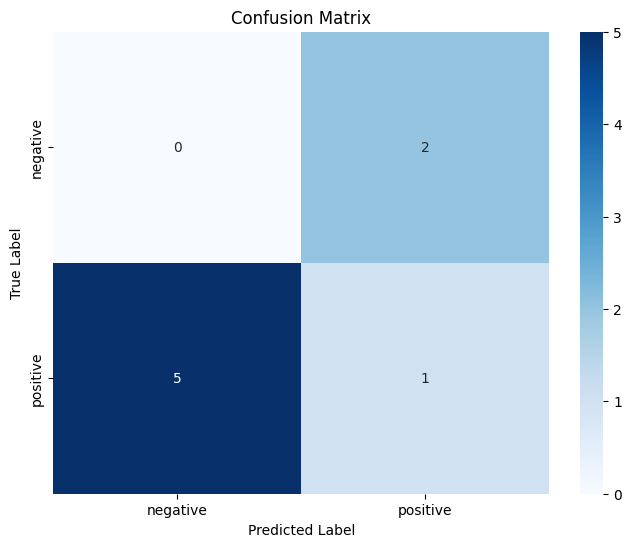


=== BINARY NB ===

classification_report:
              precision    recall  f1-score   support

    negative       0.25      1.00      0.40         2
    positive       0.00      0.00      0.00         6

    accuracy                           0.25         8
   macro avg       0.12      0.50      0.20         8
weighted avg       0.06      0.25      0.10         8





Evaluation Rsults:

--------------------------------------------------
  negative: Precision=0.250, Recall=1.000, F1-Score=0.400
  positive: Precision=0.000, Recall=0.000, F1-Score=0.000

Macro-Averaged F1: 0.200

Micro-Averaged F1: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

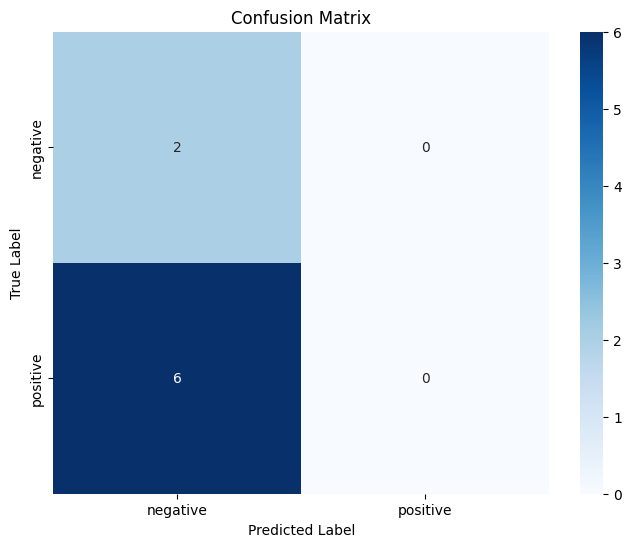

In [132]:
### Just 24 documents gives a poor result but it is the correct one

if len(X_test) > 0:
  class_names = ['negative', 'positive']
  print("=== MULTINOMIAL NB ===")
  evaluate_classifier(multinomial_nb, X_test_counts, y_test, class_names)

  print("\n=== BINARY NB ===")
  evaluate_classifier(binary_nb, X_test_binary, y_test, class_names)

## Cross Validation

In [79]:
def perform_cross_validation(texts, labels, k=5):
  """K-fold cross validation as described in the book"""

  vectorizer = CountVectorizer()           # Create vectorizer
  X = vectorizer.fit_transform(texts)      # Convert texts to feature matrix
  print("X: ",str( X[:10]))

  y = np.array(labels)                     # Convert labels to numpy array
  print("Y: ", str(y))

  # Creating stratified k-fold cross-validator
  cv = StratifiedKFold(n_splits = k,
                       shuffle = True,    # Shuffle before sampling
                       random_state = 42)

  print("\n\n")
  # Test different classifiers
  classifiers = {
      'Multinomial NB': MultinomialNB(alpha=1.0 ),
      'Binary NB': BernoulliNB(alpha=1.0)
  }

  for name, classifier in classifiers.items():
    scores = cross_val_score(classifier, X, y,
                             cv = cv,
                             scoring = 'f1_macro')

    print(f"{name}: {scores.mean():.3f} (+/- {scores.std()*2:.3f})")  # Show mean and standard deviation (confidence interval)




In [80]:
# Exaple
perform_cross_validation(processed_texts, labels, k=3)  # Use k=3 for small dataset


X:  <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 82 stored elements and shape (10, 130)>
  Coords	Values
  (0, 70)	1
  (0, 116)	1
  (0, 75)	1
  (0, 64)	1
  (0, 112)	1
  (0, 23)	1
  (0, 125)	1
  (0, 102)	1
  (0, 60)	1
  (1, 115)	2
  (1, 33)	1
  (1, 62)	1
  (1, 56)	1
  (1, 8)	1
  (1, 5)	1
  (1, 105)	1
  (1, 10)	1
  (1, 55)	1
  (2, 115)	2
  (2, 105)	1
  (2, 63)	2
  (2, 123)	2
  (2, 86)	1
  (2, 128)	1
  (2, 84)	1
  :	:
  (6, 52)	1
  (6, 80)	1
  (6, 110)	1
  (7, 8)	1
  (7, 77)	1
  (7, 66)	1
  (7, 91)	1
  (7, 20)	1
  (7, 68)	1
  (7, 42)	1
  (7, 111)	1
  (8, 116)	1
  (8, 75)	1
  (8, 1)	1
  (8, 51)	1
  (8, 17)	1
  (8, 65)	1
  (8, 106)	1
  (8, 129)	1
  (9, 8)	1
  (9, 22)	1
  (9, 2)	1
  (9, 126)	1
  (9, 28)	1
  (9, 117)	1
Y:  ['positive' 'positive' 'negative' 'negative' 'positive' 'negative'
 'positive' 'negative' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'positive' 'p

#####Multinomial NB slightly wins by 0.019 points
#####Both perform similarly
#####Difference is small and likely not statistically significant
##### Adding more data is required

##Statistical Significance Testing

In [84]:
def bootstrap_test(scores_a, scores_b, n_bootstrap=1000):
  """
  Simplified bootstrap test for comparing two classifiers
  Paired bootstrap based on the book
  """

  observed_diff = np.mean(scores_a) - np.mean(scores_b) # δ(x) The Effect Size

  # Bootstrap resampling procedure
  bootstrap_diffs = []
  combined_scores = list(zip(scores_a, scores_b))

  for _ in range(n_bootstrap):
    # Resample with replacement
    resampled = random.choices( combined_scores, k = len(combined_scores))
    resampled_a, resampled_b = zip(*resampled)

    diff = np.mean(resampled_a) - np.mean(resampled_b) ## Checking again the difference to verify if it is still the same δ(x)
    bootstrap_diffs.append(diff)

  # Counting how often bootstrap difference ≥ 2 * observed difference as appears in the book
  extreme_count = sum(1 for diff in bootstrap_diffs if diff >= 2 * observed_diff)
  print("extreme_count: ", str(extreme_count))

  # Calculation of P-Value
  p_value = extreme_count / n_bootstrap # proportion of extreme cases

  return observed_diff, p_value




In [115]:
# Example usage (would need actual score data from multiple test runs)
scores_classifier_a = [0.85, 0.82, 0.88, 0.86, 0.84]  # Performance scores for classifier A
scores_classifier_b = [0.2, 0.82, 0.7, 0.7, 0.34]  # Performance scores for classifier B
diff, p_val = bootstrap_test(scores_classifier_a, scores_classifier_b)
print(f"Observed difference: {diff:.3f}, p-value: {p_val:.3f}")
if p_val <= 0.01: print("There is a statistically significant difference") ## Although some authors recommend even a lower threshold for NLP

extreme_count:  4
Observed difference: 0.298, p-value: 0.004
There is a statistically significant difference


## Sentiment Lexicons

In [87]:
positive_words = {
    'great', 'awesome', 'fantastic', 'excellent', 'wonderful',
    'amazing', 'brilliant', 'outstanding', 'perfect', 'love',
    'beautiful', 'incredible', 'superb', 'marvelous', 'fabulous'
}

negative_words = {
    'terrible', 'awful', 'horrible', 'bad', 'worst',
    'pathetic', 'disgusting', 'hate', 'ridiculous', 'boring',
    'stupid', 'useless', 'disappointing', 'annoying', 'frustrating'
}

In [88]:
def lexicon_features(text):
  """Extract lexicon-based features from text"""

  words = text.lower().split()

  # Count of positive and negative words
  pos_count = sum(1 for word in words if word in positive_words)
  neg_count = sum(1 for word in words if word in negative_words)

  # Retrieves feature dictionary
  return{
      'positive_word_count': pos_count,
      'negative_word_count': neg_count,
      'sentiment_score': pos_count - neg_count
  }



In [89]:
# Example usage
text = "This movie is awesome but the ending was terrible"
features = lexicon_features(text)
print("Lexicon features:", features)  # Should show: positive=1, negative=1, score=0

Lexicon features: {'positive_word_count': 1, 'negative_word_count': 1, 'sentiment_score': 0}


## Complete Pipeline Example

In [147]:
class SentimentClassifier:
  """Complete sentiment classification pipeline"""

  def __init__(self, use_negation=True, use_binary=True, remove_stopwords=False):
    self.use_negation = use_negation # Negation handling. Adding prefix NOT_
    self.use_binary = use_binary # Binary NB
    self.remove_stopwords = remove_stopwords

    self.vectorizer = CountVectorizer(binary=use_binary) # Binary vectorizer

    self.classifier = BernoulliNB() if use_binary else MultinomialNB()

    if self.remove_stopwords:
      self.stop_words = set(stopwords.words('english'))


  def preprocess(self, texts):
    """Applying preprocessing with negation handling included"""

    processed = []

    for text in texts:

      if self.use_negation:
        text = handle_negation(text) # Handle negation while punctuation is still present


      text = re.sub('[^\w\s]', '', text.lower()) # Removes the complement of chars and spaces, and lowercases the rest


      if self.remove_stopwords:
        words = text.split()
        text = ' '.join([word for word in words if word not in self.stop_words])

      processed.append(text)

    print("\nprocessed: ", str(processed),"\n\n")
    return(processed)



  def train(self, texts, labels):
    """Train classifier on provided data"""

    processed_texts = self.preprocess(texts)
    X = self.vectorizer.fit_transform(processed_texts)
    self.classifier.fit(X, labels)

  def predict(self, texts):
    """Make predictions on new data"""
    processed_texts = self.preprocess(texts)
    X = self.vectorizer.transform(processed_texts)
    return self.classifier.predict(X)

  def predict_probability(self, texts):
    """Get the prediction probabilities per each class"""
    processed_texts = self.preprocess(texts)
    X = self.vectorizer.transform(processed_texts)
    return self.classifier.predict_proba(X)


## Example

In [148]:
classifier = SentimentClassifier(use_negation=True, use_binary=True)  # Enable both optimizations
classifier.train(texts, labels)

Detected punctuation:  movie!
Detected punctuation:  sweet,
Detected punctuation:  humor.
Detected punctuation:  fun.
Detected punctuation:  pathetic.
Detected punctuation:  scenes.
Detected negation:  No
Detected punctuation:  scenes.
Detected punctuation:  predictable.
Detected punctuation:  almonds.
Detected punctuation:  place!
Detected punctuation:  food.
Detected punctuation:  summer.
Detected punctuation:  energy.
Detected negation:  No
Detected punctuation:  surprises.
Detected punctuation:  fantastic!
Detected punctuation:  year.
Detected punctuation:  throughout.
Detected punctuation:  drama.
Detected punctuation:  recommend!
Detected punctuation:  actor.
Detected punctuation:  Amazing!
Detected punctuation:  end.
Detected punctuation:  direction.
Detected punctuation:  it!
Detected punctuation:  plot.
Detected punctuation:  ever.
Detected punctuation:  disgusting.
Detected punctuation:  disappointing.
Detected punctuation:  money.
Detected punctuation:  horrible.
Detected pu

In [149]:
## Generated complex examples
new_texts = [
    # === NEGATION EXAMPLES ===
    "I don't like this movie",                          # Simple negation - negative
    "This movie is not bad",                            # Negated negative word - positive
    "I can't say I didn't enjoy it",                    # Double negation - positive
    "It's not terrible, actually quite good",           # Negation + positive - positive
    "Never seen anything so boring",                    # Negation with boring - negative
    "Nothing about this film worked",                   # Nothing negation - negative
    "Won't recommend this to anyone",                   # Won't negation - negative

    # === CLEAR POSITIVE EXAMPLES ===
    "This is a great film!",                           # Clear positive
    "Absolutely fantastic movie experience",            # Strong positive
    "Love the amazing cinematography and acting",       # Positive with specific praise
    "Perfect blend of drama and comedy",               # Positive description

    # === CLEAR NEGATIVE EXAMPLES ===
    "Terrible acting and boring plot",                 # Clear negative
    "Waste of time and money",                         # Strong negative
    "Completely disappointing experience",              # Negative experience
    "The worst movie I've ever seen",                 # Superlative negative

    # === MIXED/NEUTRAL EXAMPLES ===
    "Not bad, but could be better",                    # Mixed with negation
    "It was okay, nothing special",                    # Neutral/lukewarm
    "Good acting but terrible story",                  # Mixed positive/negative
    "Started well but ended poorly",                   # Mixed temporal sentiment

    # === DOMAIN VARIETY ===
    "The restaurant food was not good",                # Restaurant + negation
    "Amazing service and delicious food",              # Restaurant positive
    "Hotel room was dirty and overpriced",            # Hotel negative
    "Can't complain about the excellent service",      # Service + double negative

    # === EDGE CASES ===
    "Not not good",                                    # Double negation edge case
    "It's not that I don't like it",                  # Complex negation
    "I love that it's not predictable",               # Positive about negated quality
    "This doesn't suck",                              # Informal negated negative
]

In [150]:

predictions = classifier.predict(new_texts)        # Get class predictions
probabilities = classifier.predict_probability(new_texts)  # Get probability distributions

# Display results with detailed formatting
for text, pred, prob in zip(new_texts, predictions, probabilities):
  print(f"Text: '{text}'")
  print(f"Prediction: {pred}")
  # Create probability dictionary mapping class names to probabilities
  prob_dict = dict(zip(classifier.classifier.classes_, prob))
  print(f"Probabilities: {prob_dict}")
  print("-" * 50)

Detected negation:  don't
Detected negation:  not
Detected negation:  can't
Detected negation:  didn't
Detected negation:  not
Detected punctuation:  terrible,
Detected negation:  Never
Detected negation:  Nothing
Detected negation:  Won't
Detected punctuation:  film!
Detected negation:  Not
Detected punctuation:  bad,
Detected punctuation:  okay,
Detected negation:  nothing
Detected negation:  not
Detected negation:  Can't
Detected negation:  Not
Detected negation:  not
Detected negation:  not
Detected negation:  don't
Detected negation:  not

processed:  ['i dont not_like not_this not_movie', 'this movie is not not_bad', 'i cant not_say not_i didnt not_enjoy not_it', 'its not not_terrible actually quite good', 'never not_seen not_anything not_so not_boring', 'nothing not_about not_this not_film not_worked', 'wont not_recommend not_this not_to not_anyone', 'this is a great film', 'absolutely fantastic movie experience', 'love the amazing cinematography and acting', 'perfect blend of d